In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from scipy import stats

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Date Range 2016-08-23 00:00:00 - 2017-08-23 00:00:00


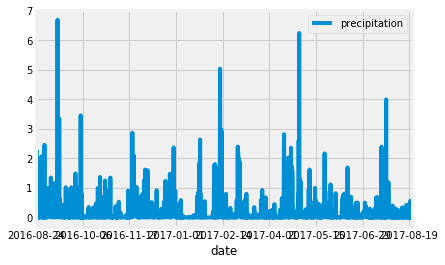

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
max_date = session.query(func.max(Measurement.date))[0][0]
max_date = dt.datetime.strptime(max_date, '%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
last_year = max_date - dt.timedelta(days=365)
print('Date Range ' + str(last_year) + ' - ' + str(max_date))

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(
                        Measurement.date >= last_year).filter(
                        Measurement.date <= max_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(results).set_index('date')
precip_df = precip_df.rename(columns={'prcp' : 'precipitation'})

# Sort the dataframe by date
# removing rows that don't have precipitation values
precip_df = precip_df.sort_values(by='date').dropna()

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot()

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station).group_by(Station.id).count()
print('Total stations is ' + str(stations))

Total stations is 9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
for station in active_stations:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_name = 'USC00519281'
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == station_name).all()

[(54.0, 85.0, 71.66378066378067)]

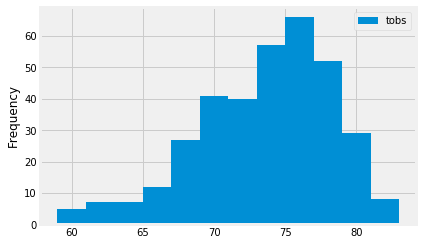

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_name = 'USC00519281'
results = session.query(Measurement.date, Measurement.tobs).filter(
                        Measurement.station == station_name).filter(
                        Measurement.date >= last_year).filter(
                        Measurement.date <= max_date).all()
temps_df = pd.DataFrame(results)
temps_df.plot.hist(bins=12)

![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-01-05', '2017-02-05'))

[(59.0, 69.64321608040201, 81.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-01-05', '2016-02-05'))
tmin, tave, tmax = calc_temps('2016-01-05', '2016-02-05')[0]

[(61.0, 69.68041237113403, 78.0)]


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


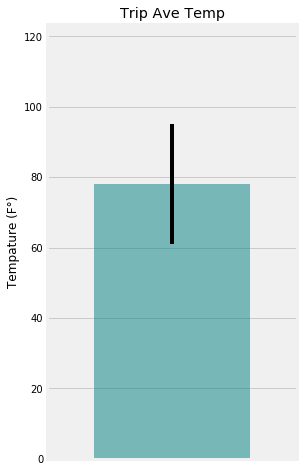

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax=plt.subplots (figsize=plt.figaspect(2.))
x=1 
yerr=tmax-tmin
bar=ax.bar(x, tmax, yerr=yerr, alpha=0.5, color='teal')
ax.set(xticks=range(x), xticklabels="a", title="Trip Ave Temp", ylabel="Tempature (F°)")
ax.margins(.3,.3)
fig.show()


## Optional Challenge Assignment

In [19]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# Hawaii is reputed to enjoy mild weather all year.
# Is there a meaningful difference between the temperature in, for example, June and December?


# You may either use SQLAlchemy
results = session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).all()
tempature_df = pd.DataFrame(results)
tempature_df['date'] = pd.to_datetime(tempature_df['date'], infer_datetime_format=True)
tempature_df = tempature_df.set_index('date')
tempature_df.head()

,station,prcp,tobs
date,,,
2010-01-01,USC00519397,0.08,65.0
2010-01-02,USC00519397,0.00,63.0
2010-01-03,USC00519397,0.00,74.0
2010-01-04,USC00519397,0.00,76.0
2010-01-06,USC00519397,NaN,73.0


In [20]:
# Identify the average temperature in June at all stations across all available years in the dataset. 
# Do the same for December temperature.

jun_data = tempature_df[tempature_df.index.month ==6]
print('JUNE')
print(jun_data.mean())
print('-------------------')
print('DECEMBER')
dec_data = tempature_df[tempature_df.index.month ==12]
print(dec_data.mean())


JUNE
prcp     0.136360
tobs    74.944118
dtype: float64
-------------------
DECEMBER
prcp     0.216819
tobs    71.041529
dtype: float64


In [21]:
# Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
jun_temp = jun_data.tobs
dec_temp = dec_data.tobs
stats.ttest_ind(jun_temp, dec_temp)
# Will you use a paired t-test, or an unpaired t-test? Why?
# I Selected a paired t-test becuase the paired option is for samples that have the same test subjects -- ie. Hawaii tempature location is the same

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)